In [1]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models # redundant ish import -- resolve later

In [2]:
df = pd.read_csv('../codes.csv') # reads in codes csv as a mutable df :-) contains message, ecl, code, dft cols
df['code']

0       1111111010111000101010111111110000010100011111...
1       1111111001100101001100111111110000010110000101...
2       1111111011111011001010111111110000010110111010...
3       1111111000100100011100111111110000010001011000...
4       1111111001000100001100111111110000010011001111...
                              ...                        
9994    1111111000110111101100111111110000010100010110...
9995    1111111010100111111010111111110000010111101101...
9996    1111111011101111111000111111110000010001011001...
9997    1111111001100110001010111111110000010010100101...
9998    1111111001010001011100111111110000010011101100...
Name: code, Length: 9999, dtype: object

In [3]:
df['code_oned'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x])) # adds a code_oned column to our df which parses our entries from strs to ints

In [4]:
# grabs a centered subarray of a given array with dimensions (2L+1) by (2L+1)
def get_centered_subarray(array, L):
    # old way -- 
    # L = (L * 2) + 1
    # start = center - (L // 2)
    # end = center + (L + 1) // 2
    n = array.shape[0]
    center = n // 2
    start = center - L
    end = center + 1 + L # start count after our center square
    # Adjust indices to stay within array bounds
    start = max(0, start)
    end = min(n, end)
    return array[start:end, start:end]

In [5]:
# function to split DFT into real and imaginary parts and reshape them
def split_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    imag_part = np.array([c.imag for c in complex_numbers])
    return real_part, imag_part

# apply the function to each row
df['dft_real'], df['dft_imag'] = zip(*df['dft'].apply(split_dft))


In [6]:
# function to take dft string into complex tuple stored as (a, ib)
def combine_dft_full(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    # real_part = zero_pad_right(0.5, real_part)
    imag_part = np.array([c.imag for c in complex_numbers])
    # imag_part = zero_pad_right(0.5, imag_part)
    return np.append(real_part, imag_part)

df['dft_stacked'] = df['dft'].apply(combine_dft_full)

In [7]:
# Features (X) - DFT components
X = np.stack(df['dft_stacked'].values)  # Shape: (num_samples, 1682) - (flat) total input data

# Labels (y) - QR codes
y = np.stack(df['code_oned'].values)  # Shape: (num_samples, 841) - (flat)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # decide on a rseed of 42 and a set set of 20%

In [8]:
# initializes our model :-)
def init_model(L):
    model = tf.keras.Sequential()
    
    # Add the input layer (implicitly defined by the first layer)
    model.add(tf.keras.layers.InputLayer(input_shape=((((L*2)+1)**2)*2,))) # shape is twice the size of our L box, one for real part and one for imaginary
    
    # Add the output layer with Y units (no activation for regression, 'softmax' or 'sigmoid' for classification)
    model.add(tf.keras.layers.Dense(841))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    # Compile the model (use appropriate loss and metrics for your task)
    model.compile(optimizer=optimizer, loss='mse')  # or 'categorical_crossentropy' for classification
    return model

In [9]:
def evaluate_model(model, X_test, y_test, num_samples=5):
    """
    evaluates the trained model on the test set and displays a few samples with their predictions.

    parameters:
    - model: The trained TensorFlow/Keras model.
    - X_test: The input features for the test set (shape: (num_samples, 1682)).
    - y_test: The true labels for the test set (shape: (num_samples, 841)).
    - num_samples: The number of test samples to display.

    returns:
    - accuracy: The overall accuracy of the model on the test set.
    """
    # make predictions on the test set
    predictions = model.predict(X_test)
    
    # binarize the predictions (0 or 1)
    predictions_binarized = (predictions > 0.5).astype(np.int32)
    
    # calculate accuracy
    correct_predictions = np.sum(predictions_binarized == y_test)
    total_elements = y_test.size
    accuracy = correct_predictions / total_elements
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # displays some predictions!
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # original QR code
        plt.subplot(1, 3, 1)
        plt.title("Original QR Code")
        plt.imshow(y_test[i].reshape(29, 29), cmap='gray')
        plt.axis('off')

        # predicted QR code
        plt.subplot(1, 3, 2)
        plt.title("Predicted QR Code")
        plt.imshow(predictions_binarized[i].reshape(29, 29), cmap='gray')
        plt.axis('off')

        # difference (Error)
        plt.subplot(1, 3, 3)
        plt.title("Difference (Error)")
        plt.imshow(y_test[i].reshape(29, 29) - predictions_binarized[i].reshape(29, 29), cmap='gray')
        plt.axis('off')

        plt.show()
        
    return accuracy

# # example usage:
# accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=5)


In [10]:
# rolls it to be correctly centered
df['dft_imag_rolled'] = df['dft_imag'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))
df['dft_real_rolled'] = df['dft_real'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))

# df['dft_imag_rolled'][0].shape # ensures our roll was successfull

Epoch 1/50
250/250 [==============================] - 2s 8ms/step - loss: 57.8330 - val_loss: 47.4860
Epoch 2/50
250/250 [==============================] - 2s 6ms/step - loss: 42.0819 - val_loss: 37.5375
Epoch 3/50
250/250 [==============================] - 2s 7ms/step - loss: 33.4031 - val_loss: 30.2555
Epoch 4/50
250/250 [==============================] - 2s 7ms/step - loss: 26.8852 - val_loss: 24.6291
Epoch 5/50
250/250 [==============================] - 2s 7ms/step - loss: 21.8064 - val_loss: 20.2135
Epoch 6/50
250/250 [==============================] - 2s 7ms/step - loss: 17.8103 - val_loss: 16.6318
Epoch 7/50
250/250 [==============================] - 2s 6ms/step - loss: 14.6380 - val_loss: 13.8267
Epoch 8/50
250/250 [==============================] - 2s 7ms/step - loss: 12.1098 - val_loss: 11.5186
Epoch 9/50
250/250 [==============================] - 2s 8ms/step - loss: 10.0824 - val_loss: 9.7065
Epoch 10/50
250/250 [==============================] - 2s 6ms/step - loss: 8.4525 -

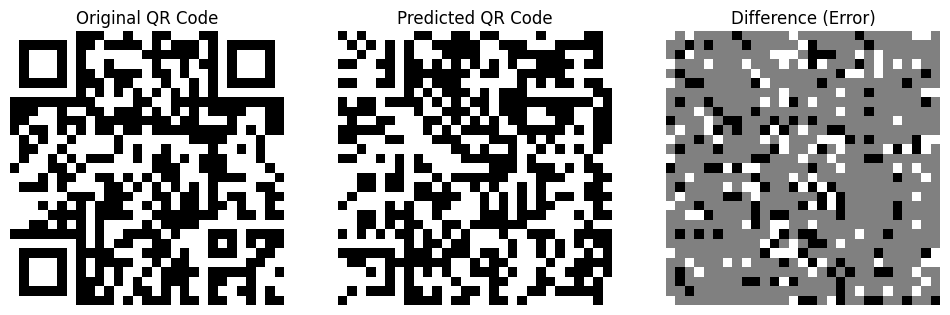

[(10, 0.7289405933876801)]
Epoch 1/50
250/250 [==============================] - 2s 6ms/step - loss: 52.6830 - val_loss: 43.3667
Epoch 2/50
250/250 [==============================] - 1s 6ms/step - loss: 38.3101 - val_loss: 34.3750
Epoch 3/50
250/250 [==============================] - 2s 6ms/step - loss: 30.5307 - val_loss: 27.8462
Epoch 4/50
250/250 [==============================] - 2s 6ms/step - loss: 24.6951 - val_loss: 22.7015
Epoch 5/50
250/250 [==============================] - 1s 6ms/step - loss: 20.1409 - val_loss: 18.7094
Epoch 6/50
250/250 [==============================] - 2s 7ms/step - loss: 16.5507 - val_loss: 15.4942
Epoch 7/50
250/250 [==============================] - 2s 6ms/step - loss: 13.6748 - val_loss: 12.9172
Epoch 8/50
250/250 [==============================] - 2s 6ms/step - loss: 11.3753 - val_loss: 10.8370
Epoch 9/50
250/250 [==============================] - 2s 7ms/step - loss: 9.5206 - val_loss: 9.1446
Epoch 10/50
250/250 [==============================] - 2s

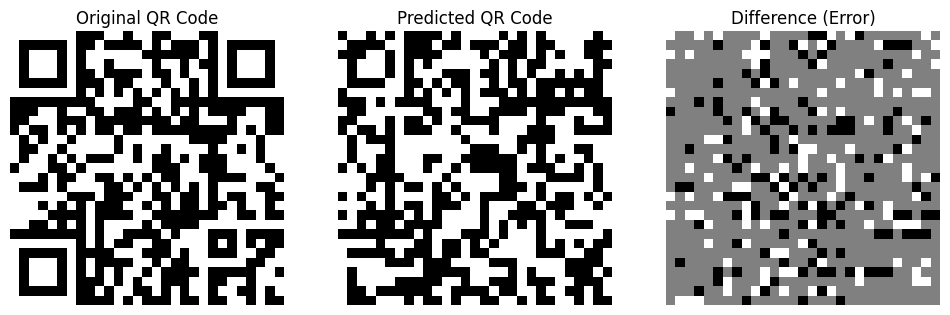

[(10, 0.7289405933876801), (9, 0.7158252187978704)]
Epoch 1/50
250/250 [==============================] - 2s 7ms/step - loss: 47.1629 - val_loss: 38.7640
Epoch 2/50
250/250 [==============================] - 2s 6ms/step - loss: 34.2841 - val_loss: 30.7089
Epoch 3/50
250/250 [==============================] - 2s 7ms/step - loss: 27.4069 - val_loss: 24.8746
Epoch 4/50
250/250 [==============================] - 2s 7ms/step - loss: 22.2716 - val_loss: 20.4143
Epoch 5/50
250/250 [==============================] - 2s 6ms/step - loss: 18.2563 - val_loss: 16.8688
Epoch 6/50
250/250 [==============================] - 2s 7ms/step - loss: 15.0769 - val_loss: 14.0556
Epoch 7/50
250/250 [==============================] - 2s 9ms/step - loss: 12.5227 - val_loss: 11.7736
Epoch 8/50
250/250 [==============================] - 2s 6ms/step - loss: 10.4694 - val_loss: 9.8993
Epoch 9/50
250/250 [==============================] - 2s 8ms/step - loss: 8.8089 - val_loss: 8.3729
Epoch 10/50
250/250 [============

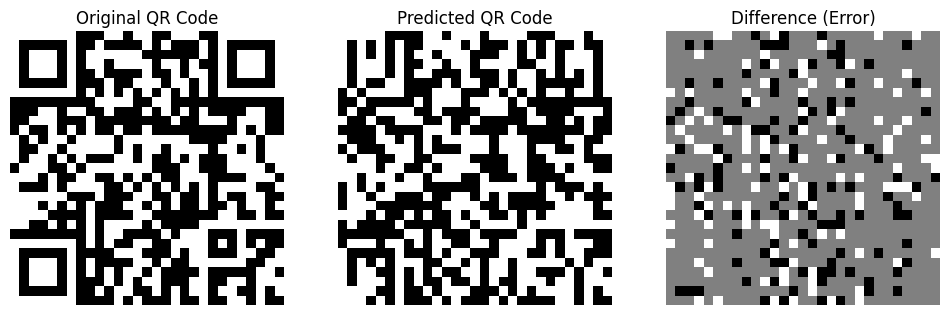

[(10, 0.7289405933876801), (9, 0.7158252187978704), (8, 0.704428566497532)]
Epoch 1/50
250/250 [==============================] - 2s 5ms/step - loss: 40.6050 - val_loss: 33.4131
Epoch 2/50
250/250 [==============================] - 2s 7ms/step - loss: 29.3205 - val_loss: 26.3856
Epoch 3/50
250/250 [==============================] - 1s 6ms/step - loss: 23.4839 - val_loss: 21.4913
Epoch 4/50
250/250 [==============================] - 2s 6ms/step - loss: 19.1668 - val_loss: 17.6671
Epoch 5/50
250/250 [==============================] - 2s 8ms/step - loss: 15.7998 - val_loss: 14.6780
Epoch 6/50
250/250 [==============================] - 2s 6ms/step - loss: 13.1131 - val_loss: 12.3015
Epoch 7/50
250/250 [==============================] - 2s 7ms/step - loss: 10.9547 - val_loss: 10.3347
Epoch 8/50
250/250 [==============================] - 2s 8ms/step - loss: 9.2103 - val_loss: 8.7003
Epoch 9/50
250/250 [==============================] - 2s 7ms/step - loss: 7.7894 - val_loss: 7.4152
Epoch 10/5

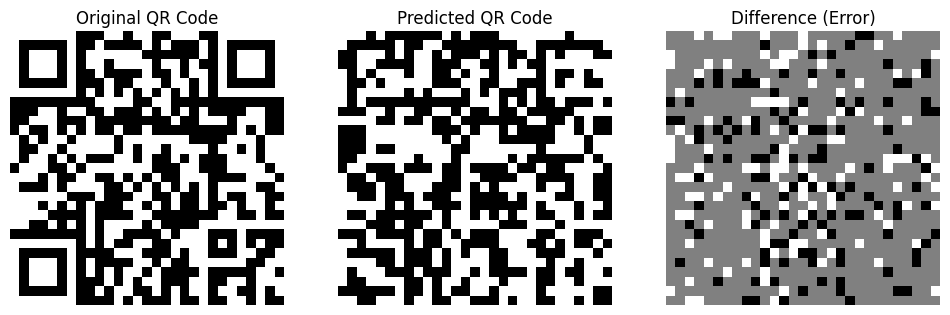

[(10, 0.7289405933876801), (9, 0.7158252187978704), (8, 0.704428566497532), (7, 0.6968026290261724)]
Epoch 1/50
250/250 [==============================] - 2s 6ms/step - loss: 34.2856 - val_loss: 27.8523
Epoch 2/50
250/250 [==============================] - 2s 7ms/step - loss: 24.5187 - val_loss: 21.9542
Epoch 3/50
250/250 [==============================] - 2s 6ms/step - loss: 19.6399 - val_loss: 17.8985
Epoch 4/50
250/250 [==============================] - 2s 8ms/step - loss: 16.0819 - val_loss: 14.7558
Epoch 5/50
250/250 [==============================] - 1s 6ms/step - loss: 13.3075 - val_loss: 12.3176
Epoch 6/50
250/250 [==============================] - 2s 6ms/step - loss: 11.0944 - val_loss: 10.3121
Epoch 7/50
250/250 [==============================] - 1s 5ms/step - loss: 9.3113 - val_loss: 8.7157
Epoch 8/50
250/250 [==============================] - 1s 5ms/step - loss: 7.8602 - val_loss: 7.4109
Epoch 9/50
250/250 [==============================] - 1s 6ms/step - loss: 6.6798 - val_

KeyboardInterrupt: 

In [12]:
L = 10
stat = []
for L in range(10,0,-1):
    # adds L cols to df, one for real/imag component
    df['L_imag'] = df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())
    df['L_real']= df['dft_real_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())
    # concats real and imag components into a single col
    df['L'] = df.apply(lambda row: np.concatenate((row['L_real'], row['L_imag'])), axis=1)
    model = init_model(L) # inits our model
    
    # features (X) - DFT components
    X = np.stack(df['L'].values)  # shape: (num_samples, ((L*2)+1)*2) - due to dims of L box * 2 for real and imag
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # calculate and append (L, accuracy)
    model.fit(X_train, y_train, epochs=50, validation_data=[X_test[1000:], y_test[1000:]])
    accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=1)
    stat.append((L, accuracy))

    print(stat)

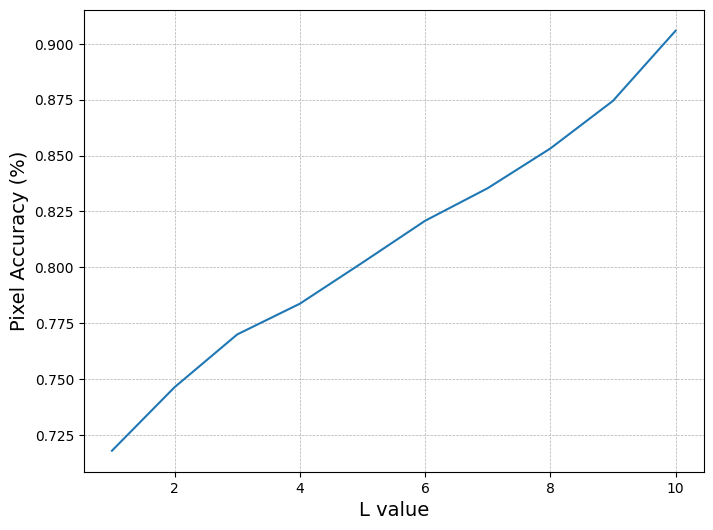

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('L value', fontsize=14)
ax.set_ylabel('Pixel Accuracy (%)', fontsize=14)
ax.plot([st[0] for st in stat], [st[1] for st in stat]) # plots accuracy vs L -- we can add labels later!

In [25]:
fig.savefig('200_epoch_accuracy.png', dpi=300)

C:\Users\kenne\AppData\Local\Temp\ipykernel_23916\1874420792.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [26]:
stat

[(10, 0.9058618666228654),
 (9, 0.8744749505748317),
 (8, 0.8531516058269922),
 (7, 0.8353835404965012),
 (6, 0.8207922547993891),
 (5, 0.8020684180018306),
 (4, 0.7836742807016291),
 (3, 0.7699221218840719),
 (2, 0.746309924669021),
 (1, 0.7178724503338059)]